In [1]:
import pandas as pd
import utils
import numpy as np
import plotly.express as px

np.random.seed(9000)

In this notebook we calculate `mean average precision` and `mean Precision@r` values for a subset of the plates (U2OS at the longest time point) whose features were extracted using a pre-trained neural network. The following are the steps taken
1. Augmented ORF, CRISPR and Compound profiles are read and the replicate plates are merged into a single dataframe.
2. The augmented ORF, CRISPR and Compound profiles are spherized separately.
3. Negative control and empty wells are removed from the dataframe.
4. Negative control and empty wells are removed from the dataframe.
5. Average precision (AP) is computed for each replicate of each perturbation and the mean average precision (mAP) is computed for each condition. Similarly, the mean precision@r (mP@r) is computed.
6. The same is repeated after shuffling the dataframe which is an estimate of the null distribution.
7. Table of precision values is printed and bar plots of precision values are plotted.

In [2]:
cell = "U2OS"
precision_df = pd.DataFrame()
group_by_feature = 'Metadata_broad_sample'
batch = "2020_11_04_CPJUMP1_DL"
all_percent_perturbation_df = pd.DataFrame()

experiment_df = (
    pd.read_csv('output/experiment-metadata.tsv', sep='\t')
    .query('Batch==@batch')
)

In [3]:
for modality in experiment_df.Perturbation.unique():
    modality_df = experiment_df.query('Perturbation==@modality')
    for time_point in modality_df.Time.unique():
        time_df = modality_df.query('Time==@time_point')
        all_plates_df = pd.DataFrame()
        for plate in time_df.Assay_Plate_Barcode.unique():
            plate_df = utils.load_data(batch, plate, "spherized.csv.gz")
            all_plates_df = utils.concat_profiles(all_plates_df, plate_df)

        all_plates_df = utils.remove_negcon_empty_wells(all_plates_df)

        score = utils.PrecisionScores(all_plates_df, all_plates_df, group_by_feature, within=True)

        precision_df = precision_df.append({'Description':f'{modality}_{cell}_{time_point}',
                                            'Modality':f'{modality}',
                                            'Cell':f'{cell}',
                                            'time':f'{time_point}',
                                            'mAP':f'{score.map:.3f}',
                                            'mPr':f'{score.mpr:.3f}',
                                            'feature_set_replicates':'DP_Real'}, ignore_index=True)

        all_plates_shuffled_df = utils.shuffle_profiles(all_plates_df)
        score_shuffled = utils.PrecisionScores(all_plates_shuffled_df, all_plates_shuffled_df, group_by_feature, within=True)

        precision_df = precision_df.append({'Description':f'{modality}_{cell}_{time_point}',
                                            'Modality':f'{modality}',
                                            'Cell':f'{cell}',
                                            'time':f'{time_point}',
                                            'mAP':f'{score_shuffled.map:.3f}',
                                            'mPr':f'{score_shuffled.mpr:.3f}',
                                            'feature_set_replicates':'DP_Permuted'}, ignore_index=True)

        percent_perturbation_df = utils.precision_at_r_threshold(score.pr_group, score_shuffled.pr_group)
        percent_perturbation_df['Modality'] = f'{modality}'
        percent_perturbation_df['Cell'] = f'{cell}'
        percent_perturbation_df['time'] = f'{time_point}'

        all_percent_perturbation_df = utils.concat_profiles(all_percent_perturbation_df, percent_perturbation_df)

In [4]:
print(precision_df[['Description','feature_set_replicates', 'mAP', 'mPr']].query('feature_set_replicates=="DP_Real"').to_markdown(index=False))

| Description      | feature_set_replicates   |   mAP |   mPr |
|:-----------------|:-------------------------|------:|------:|
| compound_U2OS_48 | DP_Real                  | 0.464 | 0.433 |
| crispr_U2OS_144  | DP_Real                  | 0.24  | 0.223 |
| orf_U2OS_96      | DP_Real                  | 0.217 | 0.192 |


In [5]:
print(precision_df[['Description','feature_set_replicates', 'mAP', 'mPr']].query('feature_set_replicates=="DP_Permuted"').to_markdown(index=False))

| Description      | feature_set_replicates   |   mAP |   mPr |
|:-----------------|:-------------------------|------:|------:|
| compound_U2OS_48 | DP_Permuted              | 0.004 | 0.003 |
| crispr_U2OS_144  | DP_Permuted              | 0.004 | 0.003 |
| orf_U2OS_96      | DP_Permuted              | 0.01  | 0.005 |


In [6]:
precision_df['mAP'] = precision_df['mAP'].astype(float)
precision_df['mPr'] = precision_df['mPr'].astype(float)

precision_df.loc[(precision_df.Modality=='compound') & (precision_df.time=='24'), 'time'] = 'short'
precision_df.loc[(precision_df.Modality=='compound') & (precision_df.time=='48'), 'time'] = 'long'
precision_df.loc[(precision_df.Modality=='crispr') & (precision_df.time=='96'), 'time'] = 'short'
precision_df.loc[(precision_df.Modality=='crispr') & (precision_df.time=='144'), 'time'] = 'long'
precision_df.loc[(precision_df.Modality=='orf') & (precision_df.time=='48'), 'time'] = 'short'
precision_df.loc[(precision_df.Modality=='orf') & (precision_df.time=='96'), 'time'] = 'long'

plot_df = (
    precision_df.rename(columns={'Modality':'Perturbation'})
)

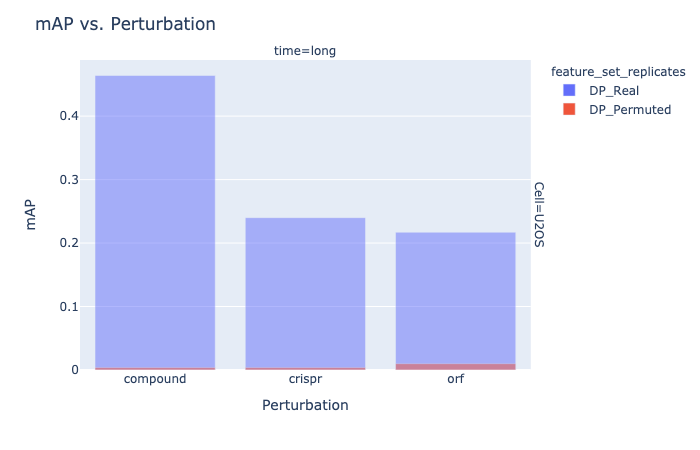

In [7]:
fig = px.bar(data_frame=plot_df,
             x='Perturbation',
             y='mAP',
             color='feature_set_replicates',
             barmode='overlay',
             facet_row='Cell',
             facet_col='time')
fig.update_layout(title='mAP vs. Perturbation',
                  yaxis=dict(title='mAP'),
                  yaxis3=dict(title='mAP'))
fig.show("png")
fig.write_image(f'figures/12.mAP_CellProfiler.png', width=640, height=480, scale=2)

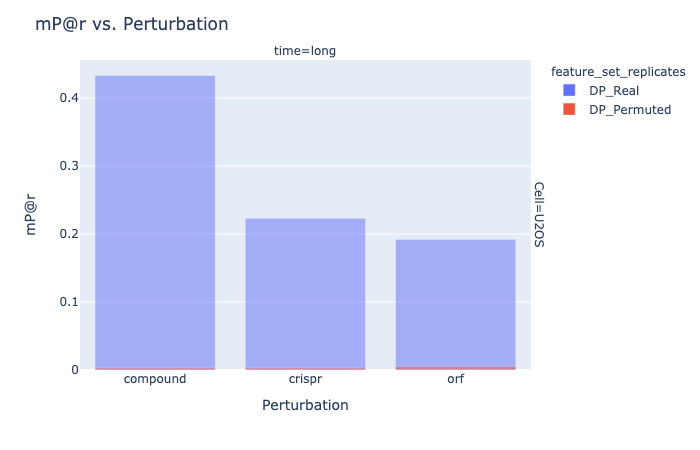

In [8]:
fig = px.bar(data_frame=plot_df,
             x='Perturbation',
             y='mPr',
             color='feature_set_replicates',
             barmode='overlay',
             facet_row='Cell',
             facet_col='time')
fig.update_layout(title='mP@r vs. Perturbation',
                  yaxis=dict(title='mP@r'),
                  yaxis3=dict(title='mP@r'))
fig.show("png")
fig.write_image(f'figures/12.mPr_CellProfiler.png', width=640, height=480, scale=2)

In [9]:
plot_df.to_csv('output/deepprofiler_precision_scores.csv', index=False)

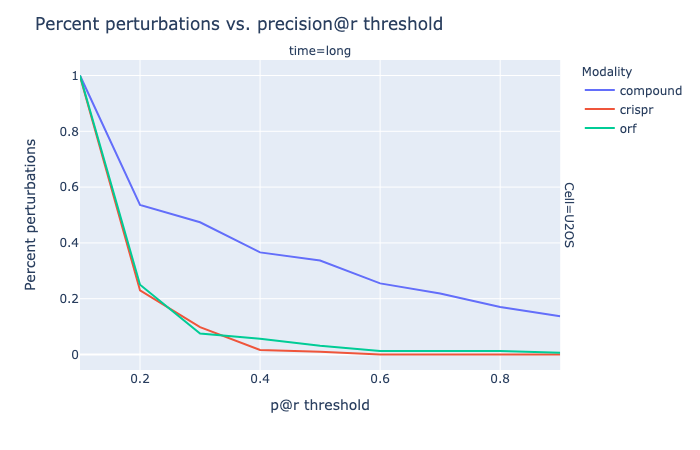

In [10]:
all_percent_perturbation_df.loc[(all_percent_perturbation_df.Modality=='compound') & (all_percent_perturbation_df.time=='24'), 'time'] = 'short'
all_percent_perturbation_df.loc[(all_percent_perturbation_df.Modality=='compound') & (all_percent_perturbation_df.time=='48'), 'time'] = 'long'
all_percent_perturbation_df.loc[(all_percent_perturbation_df.Modality=='crispr') & (all_percent_perturbation_df.time=='96'), 'time'] = 'short'
all_percent_perturbation_df.loc[(all_percent_perturbation_df.Modality=='crispr') & (all_percent_perturbation_df.time=='144'), 'time'] = 'long'
all_percent_perturbation_df.loc[(all_percent_perturbation_df.Modality=='orf') & (all_percent_perturbation_df.time=='48'), 'time'] = 'short'
all_percent_perturbation_df.loc[(all_percent_perturbation_df.Modality=='orf') & (all_percent_perturbation_df.time=='96'), 'time'] = 'long'

fig = px.line(all_percent_perturbation_df,
              x='threshold',
              y='percent_perturbations',
              color='Modality',
              facet_row='Cell',
              facet_col='time')
fig.update_layout(title='Percent perturbations vs. precision@r threshold',
                  xaxis1=dict(title='p@r threshold'),
                  xaxis2=dict(title='p@r threshold'),
                  yaxis1=dict(title='Percent perturbations'),
                  yaxis3=dict(title='Percent perturbations'))
fig.show("png")
fig.write_image(f'figures/12.percent_perturbation_curves.png', width=640, height=480, scale=2)